# About this Notebook

The purpose of this notebook is to resume the data treated previously in notebook 1 and to study if a MLP model is adapted to the problem. We also bring a critical look on the solution that has been brought to the challenge.

# Table of Contents

# Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tabulate import tabulate


import torch
from scipy import signal
from tqdm.notebook import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import random

import magnav

from torch.utils.data import Dataset, DataLoader

In [2]:
torch.manual_seed(27) # For reproducibility

# Introduction

A solution to the MIT challenge has been proposed. It is based on MLP with 3 hidden layers containing 80,40 and 20 neurones respectively with a tanh activattion function. The architecture can be seen below :<br>
<img src="../data/external/Images/FCnet.png" alt="fcnet" width="1500"/>
<br>
This solution takes as input 11 features which are :
- FLUXB_TOT
- FLUXB_X
- FLUXC_TOT
- FLUXC_Y
- FLUXD_Y
- FLUXD_Z
- UNCOMPMAG3 (with Tolles-Lawson correction)
- UNCOMPMAG3
- UNCOMPMAG4 (with Tolles-Lawson correction)
- UNCOMPMAG5 (with Tolles-Lawson correction)
- V_CABT

These 11 features are then passed in a low pass filter. A 10-point rolling average is performed and then the data is normalized. We then create a time frame of 0.5s seconds where we try to predict the time $t_0$ by entering $[t_0-2,t_0-1,t_0,t_0+1,t_0+2]$.<br>
For more details, [click here](https://github.com/lw-kong/MagNav)

This solution has very good results on flight 1003 :
<br><img src="../data/external/Images/100302_predict.png" title="Section 1003.02 prediction" width="500"/><img src="../data/external/Images/100302_rmse.png" title="Section 1003.02 rmse" width="500"/><br>

Unfortunately, the model does not generalize well. We see it notably on flight 1002 where the order of magnitude of the error goes from ten nano teslas to a hundred nano teslas. We can also see that they used sections 1003.02 and 1003.08 as training and section 1003.04 as validation. Except that as seen in notebook 1 in section 7, you have to be careful with the data overlapp. Here are som results on flight 1002 :
<br><img src="../data/external/Images/1369_predict.png" title="Section 1369.02 prediction" width="500"/><img src="../data/external/Images/1369_rmse.png" title="Section 1369 rmse" width="500"/><br>
<br><img src="../data/external/Images/100205_predict.png" title="Section 1002.05 prediction" width="500"/><img src="../data/external/Images/100205_rmse.png" title="Section 1002.05 rmse" width="500"/><br>

This model does not answer to what we want to do, that is to say a model able to generalize on different flights. So we will try to create a more generalized model. A reasonable limit would be a model that generalizes on different flights over a time range (e.g. 1 year) for an aircraft type. We will therefore try to see in this notebook if a MLP type model can be adapted to our problem.

# 1 - What is an MLP ?

A MLP (multilayer perceptron) is a fully connected class of feedforward artificical neural network (ANN). The term MLP is used ambiguously, sometimes loosely to mean any feedforward ANN, sometimes to refer strictly to networks composed of multiple layers of perceptron (with treshold activation).<br>
An MLP consists of at least three layers of nodes :
- an input layer
- a hidden layer
- an output layer

Except for the inputs nodes, each node is a neuron that uses a nonlinear activation function. MLP utilizes a supervised learning technique called [backpropagation](https://en.wikipedia.org/wiki/Backpropagation) for training. Its multiple layers and non-linear activation distinguish MLP from a linear perceptron. It can distinguish data that is not linearly separable. Here is an exemple of an MLP :
<br><img src="../data/external/Images/MLP example.png" title="MLP" width="500"/><br>

# 2 - Import of data

In [3]:
df1002 = pd.read_hdf('../data/interim/dataset.h5', key=f'Flt1002')
df1003 = pd.read_hdf('../data/interim/dataset.h5', key=f'Flt1003')
df1004 = pd.read_hdf('../data/interim/dataset.h5', key=f'Flt1004')

In [4]:
df1002 = df1002.dropna()
df1002.head()

,TL_comp_mag3_cl,TL_comp_mag5_cl,V_BAT1,V_BAT2,TOPO,INS_VEL_N,INS_VEL_W,INS_VEL_V,BARO,CUR_IHTR,PITCH,ROLL,AZIMUTH,LINE,IGRFMAG1
Time [s],,,,,,,,,,,,,,,
45100.0,-1026.777805,-44.982774,25.827,2.015,71.04,-36.54755,14.52841,3.47413,109.73,1.734,9.19,0.19,204.01,1002.01,-297.343
45100.1,-1023.030351,-40.600326,25.826,2.014,71.06,-36.57182,14.49200,3.42597,110.14,1.759,9.08,-0.03,203.95,1002.01,-296.223
45100.2,-1021.286230,-34.817623,25.824,2.013,71.08,-36.60039,14.45370,3.37824,110.55,1.783,8.96,-0.22,203.91,1002.01,-295.079
45100.3,-1023.965085,-29.347438,25.820,2.010,71.07,-36.63182,14.41314,3.33233,110.95,1.796,8.85,-0.39,203.90,1002.01,-293.939
45100.4,-1030.701663,-25.421394,25.815,2.007,71.04,-36.66759,14.37150,3.28104,111.35,1.788,8.73,-0.55,203.91,1002.01,-292.821


In [5]:
# lines_2 = [158.,1002.04,160.,1002.05,3086.,1002.11,1002.14,1002.16,1002.17]
# lines_3 = [1003.08]

# df2 = pd.DataFrame()
# for line in lines_2:
#     mask     = (df1002.LINE == line)
#     df2 = pd.concat([df2,df1002.loc[mask]],axis=0)
df2 = df1002
    
# df3 = pd.DataFrame()
# for line in lines_3:
#     mask     = (df1003.LINE == line)
#     df3 = pd.concat([df3,df1003.loc[mask]],axis=0)
df3 = df1003 

df4 = df1004
    
print(df2.LINE.unique())
print(df3.LINE.unique())
print(df4.LINE.unique())

[1002.01 1002.03  158.   1002.04  160.   1002.05 1367.   1002.06 1368.
 1002.07 1369.   1002.08 3084.   1002.09 3085.   1002.1  3086.   1002.11
 1002.13 1002.14 1002.15 1002.16 1002.17 1002.18 1002.19 1002.21]
[1003.01 1003.02 1003.03 1003.04 1003.05 1003.06 1003.07 1003.08 1003.09
 1003.11]
[1004.01 4019.   4018.   4017.   4016.    421.    419.    417.    415.
  413.    411.    409.    408.    407.    405.    403.    401.   4015.
 4012.   4001.   1004.02]


# 3 - Data pre-processing

We have our 13 features that we selected in the previous notebook. It is these features that we will use as input for our model. However we can't enter our features in their current state if we want to get good results with our model. There are a few steps we need to take first.

## 3.1 - Normalization

There are different type of normalization, but there, we will use Min-max feature scaling :
<br><br>
<font size="3">
    $X' = a+\frac{(X-X_{min})(b-a)}{X_{max}-X_{min}}$
</font>
<br><br>
This allows us to put our variables in the interval $[a,b]$. This solution is preferred to a standard score because all our variables do not follow a normal distribution (see below). In our case we will restrict our values between 0 and 1.

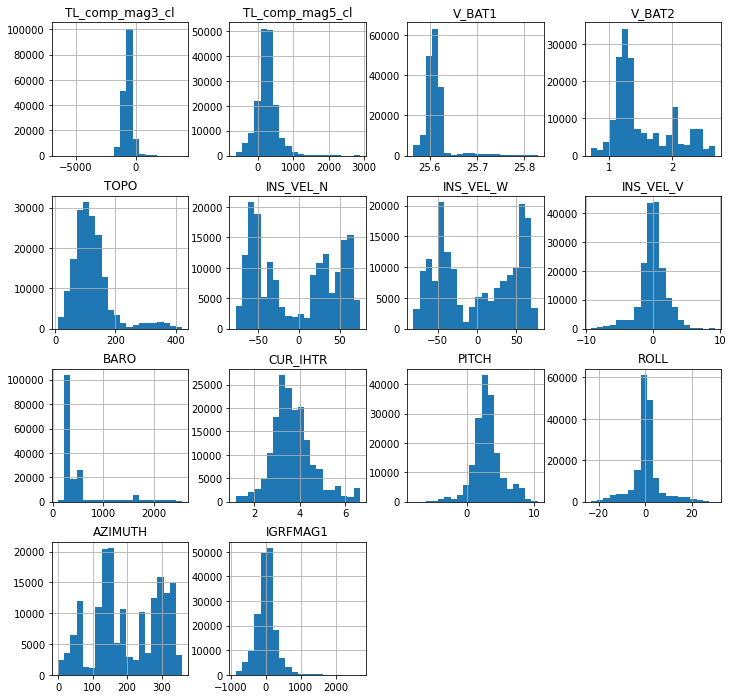

In [6]:
df2.drop(columns=['LINE']).hist(bins=20,figsize=[12,12])
plt.show()

In [7]:
df2.describe()

,TL_comp_mag3_cl,TL_comp_mag5_cl,V_BAT1,V_BAT2,TOPO,INS_VEL_N,INS_VEL_W,INS_VEL_V,BARO,CUR_IHTR,PITCH,ROLL,AZIMUTH,LINE,IGRFMAG1
count,173001.000000,173001.000000,173001.000000,173001.000000,173001.000000,173001.000000,173001.000000,173001.000000,173001.000000,173001.000000,173001.00000,173001.000000,173001.000000,173001.000000,173001.000000
mean,-672.153721,248.932134,25.613098,1.523616,121.150097,-3.107925,1.139791,-0.012206,506.941174,3.703508,3.04595,0.469931,199.112002,1182.385178,10.460371
std,340.679596,284.187814,0.030735,0.449069,64.515211,48.253921,48.907424,1.964411,455.156664,0.915227,2.12188,6.015285,95.257929,657.103602,288.018059
min,-6478.497922,-624.307913,25.565000,0.721000,9.070000,-77.338950,-80.657610,-9.253220,106.020000,1.197000,-7.98000,-23.340000,0.020000,158.000000,-868.652000
25%,-855.751405,100.595266,25.599000,1.208000,83.410000,-52.047800,-44.764190,-0.876620,282.200000,3.135000,1.95000,-1.370000,140.150000,1002.070000,-145.245000
50%,-677.575474,246.334316,25.608000,1.324000,109.140000,-3.879090,4.543080,0.035710,311.590000,3.588000,2.93000,0.410000,183.480000,1002.150000,13.981000
75%,-499.437529,382.408952,25.618000,1.895000,142.530000,45.085980,50.656650,0.959350,539.210000,4.162000,3.97000,2.090000,290.390000,1002.180000,147.156000
max,3890.319398,2878.629247,25.828000,2.671000,422.310000,74.700710,76.717810,9.285140,2565.320000,6.644000,10.54000,30.080000,360.000000,3086.000000,2699.331000


In [8]:
scaling_range = [-1,1]
MinMaxScaler_2 = MinMaxScaler(scaling_range)
MinMaxScaler_3 = MinMaxScaler(scaling_range)
MinMaxScaler_4 = MinMaxScaler(scaling_range)


df2_scaled = pd.DataFrame()
df3_scaled = pd.DataFrame()
df4_scaled = pd.DataFrame()


df2_scaled[df2.drop(columns=['LINE','IGRFMAG1']).columns] = MinMaxScaler_2.fit_transform(df2.drop(columns=['LINE','IGRFMAG1']))
df3_scaled[df3.drop(columns=['LINE','IGRFMAG1']).columns] = MinMaxScaler_3.fit_transform(df3.drop(columns=['LINE','IGRFMAG1']))
df4_scaled[df4.drop(columns=['LINE','IGRFMAG1']).columns] = MinMaxScaler_4.fit_transform(df4.drop(columns=['LINE','IGRFMAG1']))

df2_scaled.index = df2.index
df3_scaled.index = df3.index
df4_scaled.index = df4.index

df2_scaled[['LINE','IGRFMAG1']] = df2[['LINE','IGRFMAG1']]
df3_scaled[['LINE','IGRFMAG1']] = df3[['LINE','IGRFMAG1']]
df4_scaled[['LINE','IGRFMAG1']] = df4[['LINE','IGRFMAG1']]

df2_scaled.describe()

,TL_comp_mag3_cl,TL_comp_mag5_cl,V_BAT1,V_BAT2,TOPO,INS_VEL_N,INS_VEL_W,INS_VEL_V,BARO,CUR_IHTR,PITCH,ROLL,AZIMUTH,LINE,IGRFMAG1
count,173001.000000,173001.000000,173001.000000,173001.000000,173001.000000,173001.000000,173001.000000,173001.000000,173001.000000,173001.000000,173001.000000,173001.000000,173001.000000,173001.000000,173001.000000
mean,0.119963,-0.501424,-0.634235,-0.176804,-0.457554,-0.023531,0.039519,-0.003039,-0.673955,-0.079674,0.190707,-0.108576,0.106128,1182.385178,10.460371
std,0.065712,0.162257,0.233728,0.460583,0.312241,0.634754,0.621538,0.211929,0.370151,0.336048,0.229145,0.225207,0.529240,657.103602,288.018059
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,158.000000,-868.652000
25%,0.084549,-0.586117,-0.741445,-0.500513,-0.640209,-0.667309,-0.543850,-0.096295,-0.856723,-0.288416,0.072354,-0.177462,-0.221457,1002.070000,-145.245000
50%,0.118917,-0.502907,-0.673004,-0.381538,-0.515681,-0.033675,0.082770,0.002131,-0.832822,-0.122086,0.178186,-0.110820,0.019279,1002.150000,13.981000
75%,0.153277,-0.425216,-0.596958,0.204103,-0.354080,0.610434,0.668803,0.101777,-0.647713,0.088673,0.290497,-0.047922,0.613256,1002.180000,147.156000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3086.000000,2699.331000


## 3.2 - Train/Validation/Test split

In [9]:
device = magnav.get_device()
device = 'cpu'

Currently using cuda


In [10]:
class MagNavDataset(Dataset):
    # split can be 'Train', 'Val', 'Test'
    def __init__(self,df,split):
        
        features   = df.drop(columns=['LINE','IGRFMAG1']).columns.to_list()
        mask_train_1 = (df.LINE != 1002.14)
        mask_val   = (df.LINE == 1002.14)

        X_train    = df.loc[mask_train_1,features]
        y_train    = df.loc[mask_train_1,'IGRFMAG1']

        X_val      = df.loc[mask_val,features]
        y_val      = df.loc[mask_val,'IGRFMAG1']

        X_test     = df4_scaled.loc[:,features]
        y_test     = df4_scaled.loc[:,'IGRFMAG1']

        if split == 'train':
            self.X = torch.tensor(X_train.to_numpy(),dtype=torch.float32)
            self.y = torch.tensor(np.reshape(y_train.to_numpy(),[-1,1]),dtype=torch.float32)
        if split == 'val':
            self.X = torch.tensor(X_val.to_numpy(),dtype=torch.float32)
            self.y = torch.tensor(np.reshape(y_val.to_numpy(),[-1,1]),dtype=torch.float32)
        if split == 'test':
            self.X = torch.tensor(X_test.to_numpy(),dtype=torch.float32)
            self.y = torch.tensor(np.reshape(y_test.to_numpy(),[-1,1]),dtype=torch.float32)
        
        
    def __len__(self):
        return len(self.X)
        
    def __getitem__(self,idx):
        return self.X[idx], self.y[idx]

In [11]:
df_concat = pd.concat([df2_scaled,df3_scaled],ignore_index=True,axis=0)

train = MagNavDataset(df_concat,split='train')
val   = MagNavDataset(df_concat,split='val')
test  = MagNavDataset(df_concat,split='test')

In [12]:
BATCH_SIZE = 64

train_loader  = DataLoader(train,
                           batch_size=BATCH_SIZE,
                           shuffle=True,
                           num_workers=0,
                           pin_memory=False)

val_loader    = DataLoader(val,
                           batch_size=BATCH_SIZE,
                           shuffle=False,
                           num_workers=0,
                           pin_memory=False)

# 4 - Model

## 4.1 - Architecture

In [13]:
def count_parameters(model):
    
    total_params = 0
    table = np.array([["Modules","Parameters"]])

    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table = np.concatenate((table,[[name,params]]),axis=0)
        total_params += params
    table = np.concatenate((table,[["",""],["Total Trainable Params",total_params]]),axis=0)
    print(tabulate(table,headers='firstrow',tablefmt="pipe",stralign='right'))

In [14]:
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class MLP(torch.nn.Module):
    
    def __init__(self):
        super(MLP, self).__init__()
        self.architecture = torch.nn.Sequential(
            torch.nn.Linear(13,8),
            torch.nn.ReLU(),
            torch.nn.Linear(8,4),
            torch.nn.ReLU(),
            torch.nn.Linear(4,1),
        )
        self.architecture.apply(init_weights)
        
        
    def forward(self, x):
        logits = self.architecture(x)
        return logits

model_1 = MLP().to(device)
count_parameters(model_1)

|                Modules |   Parameters |
|-----------------------:|-------------:|
|  architecture.0.weight |          104 |
|    architecture.0.bias |            8 |
|  architecture.2.weight |           32 |
|    architecture.2.bias |            4 |
|  architecture.4.weight |            4 |
|    architecture.4.bias |            1 |
|                        |              |
| Total Trainable Params |          153 |


## 4.2 - Loss

In [15]:
class RMSELoss(torch.nn.Module):
    
    def __init__(self):
        super(RMSELoss,self).__init__()
        
    def forward(self,yhat,y):
        criterion = torch.nn.MSELoss()
        loss = torch.sqrt(criterion(yhat,y)+1e-6)
        return loss 

criterion = RMSELoss()

# 5 - Training

In [16]:
def make_training(model,EPOCHS):

    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3) 
    
    pbar = tqdm_notebook(total=EPOCHS,unit="epoch",desc='Training')

    train_loss_history = []
    val_loss_history = []

    for epoch in range(EPOCHS):

        #---TRAIN---#

        train_running_loss = 0.

        # Make sure gradient tracking is on, and do a pass over the data
        model.train()

        # Enumerate allow to track batch index and intra-epoch reporting 
        for batch_index, (inputs, labels) in enumerate(train_loader):

            inputs, labels = inputs.to(device), labels.to(device)

            # Make prediction for this batch
            predictions = model(inputs)

            # Compute the loss
            loss = criterion(predictions, labels)

            # Zero gradients for every batch
            optimizer.zero_grad()

            # Calculate gradients
            loss.backward()

            # Adjust learning weights
            optimizer.step()

            # Gather data and report
            train_running_loss += loss.item()

        train_loss = train_running_loss / batch_index
        train_loss_history.append(train_loss)

        #---VALIDATION---#

        val_running_loss = 0.
        
        model.eval()
        
        with torch.no_grad():
            
            for batch_index, (inputs, labels) in enumerate(val_loader):

                inputs, labels = inputs.to(device), labels.to(device)

                # Make prediction
                predictions = model(inputs)

                # Compute the loss
                loss = criterion(predictions, labels)

                # Gather data and report
                val_running_loss += loss.item()

            val_loss = val_running_loss / batch_index
            val_loss_history.append(val_loss)
        
#         with torch.no_grad():
#             pred = model(val.X_val.to(device))
            
#         true = val.y_val

#         val_loss = magnav.rmse(pred.cpu(),true)
#         val_loss_history.append(val_loss)
        
#         # Saving best validation loss
#         if epoch > 3:
#             min_val_loss = min(val_loss_history[3:])
#         else :
#             min_val_loss = 'None'
        
        pbar.set_postfix(train_loss=train_loss,val_loss=val_loss,lr=optimizer.param_groups[0]['lr'])
        pbar.update()

    return train_loss_history, val_loss_history

In [17]:
def make_evaluation(model,train_loss_history,val_loss_history):
    with torch.no_grad():

        model.eval()
        pred_val = model(val.X)
        true_val = val.y

        pred_test = model(test.X) 
        true_test = test.y
        
        fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=[30,8])
        
        ax1.plot(pred_val,label='Prediction')
        ax1.plot(true_val,label='Truth')
        ax1.legend(loc='upper right')
        ax1.set_title('Validation set')
        ax1.grid()

        rmse = magnav.rmse(pred_val,true_val)
        ax1.text(-2.391,0.968,f'RMSE={rmse:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C0',alpha=0.6),transform=plt.gca().transAxes)
        
        ax2.plot(pred_test,label='Prediction')
        ax2.plot(true_test,label='Truth')
        ax2.legend(loc='upper right')
        ax2.set_title('Test set')
        ax2.grid()

        rmse = magnav.rmse(pred_test,true_test)
        ax2.text(-1.193,0.968,f'RMSE={rmse:.2f}nT',fontsize=12,bbox=dict(facecolor = 'C0',alpha=0.6),transform=plt.gca().transAxes)

        ax3.plot(train_loss_history,label='Train loss')
        ax3.plot(val_loss_history,label='Validation loss')
        ax3.set_title('Loss')
        ax3.legend()
        ax3.grid()
        plt.savefig(f'runs/{model.name}.jpg')
        plt.show()

In [18]:
EPOCHS = 50
train_loss_history, val_loss_history = make_training(model_1,EPOCHS)

Training:   0%|          | 0/50 [00:00<?, ?epoch/s]

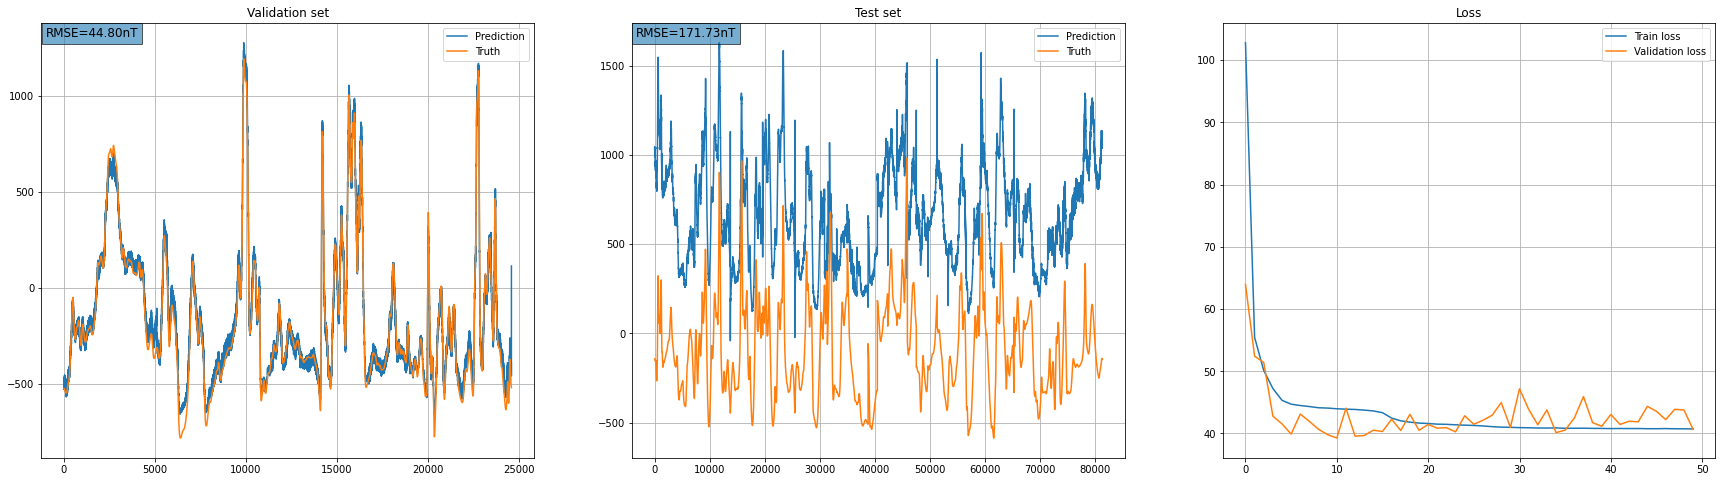

In [26]:
make_evaluation(model_1,train_loss_history,val_loss_history)

# 6 - Training multiples architectures

1 Hidden Layer

In [18]:
class MLP_1HL(torch.nn.Module):
    
    def __init__(self,neurons_HL1):
        super(MLP_1HL, self).__init__()
        self.architecture = torch.nn.Sequential(
            torch.nn.Linear(13,neurons_HL1),
            torch.nn.ReLU(),
            torch.nn.Linear(neurons_HL1,1),
        )
        self.architecture.apply(init_weights)
        
        
    def forward(self, x):
        logits = self.architecture(x)
        return logits

2 Hidden Layers

In [19]:
class MLP_2HL(torch.nn.Module):
    
    def __init__(self,neurons_HL1,neurons_HL2):
        super(MLP_2HL, self).__init__()
        self.architecture = torch.nn.Sequential(
            torch.nn.Linear(13,neurons_HL1),
            torch.nn.ReLU(),
            torch.nn.Linear(neurons_HL1,neurons_HL2),
            torch.nn.ReLU(),
            torch.nn.Linear(neurons_HL2,1),
        )
        self.architecture.apply(init_weights)
        
        
    def forward(self, x):
        logits = self.architecture(x)
        return logits

3 Hidden Layers

In [20]:
class MLP_3HL(torch.nn.Module):
    
    def __init__(self,neurons_HL1,neurons_HL2,neurons_HL3):
        super(MLP_3HL, self).__init__()
        self.architecture = torch.nn.Sequential(
            torch.nn.Linear(13,neurons_HL1),
            torch.nn.ReLU(),
            torch.nn.Linear(neurons_HL1,neurons_HL2),
            torch.nn.ReLU(),
            torch.nn.Linear(neurons_HL2,neurons_HL3),
            torch.nn.ReLU(),
            torch.nn.Linear(neurons_HL3,1),
        )
        self.architecture.apply(init_weights)
        
        
    def forward(self, x):
        logits = self.architecture(x)
        return logits

4 Hidden Layers

In [21]:
class MLP_4HL(torch.nn.Module):
    
    def __init__(self,neurons_HL1,neurons_HL2,neurons_HL3,neurons_HL4):
        super(MLP_4HL, self).__init__()
        self.architecture = torch.nn.Sequential(
            torch.nn.Linear(13,neurons_HL1),
            torch.nn.ReLU(),
            torch.nn.Linear(neurons_HL1,neurons_HL2),
            torch.nn.ReLU(),
            torch.nn.Linear(neurons_HL2,neurons_HL3),
            torch.nn.ReLU(),
            torch.nn.Linear(neurons_HL3,neurons_HL4),
            torch.nn.ReLU(),
            torch.nn.Linear(neurons_HL4,1),
        )
        self.architecture.apply(init_weights)
        
        
    def forward(self, x):
        logits = self.architecture(x)
        return logits

In [22]:
model_4   = MLP_1HL(4)
model_4.name = 'MLP_4'
model_8   = MLP_1HL(8)
model_8.name = 'MLP_8'
model_16  = MLP_1HL(16)
model_16.name = 'MLP_16'
model_256 = MLP_1HL(256)
model_256.name = 'MLP_256'

model_42   = MLP_2HL(4,2)
model_42.name = 'MLP_42'
model_84   = MLP_2HL(8,4)
model_84.name = 'MLP_84'
model_168  = MLP_2HL(16,8)
model_168.name = 'MLP_168'
model_3216 = MLP_2HL(32,16)
model_3216.name = 'MLP_3216'

model_842     = MLP_3HL(8,4,2)
model_842.name = 'MLP_842'
model_1684    = MLP_3HL(16,8,4)
model_1684.name = 'MLP_1684'
model_32168   = MLP_3HL(32,16,8)
model_32168.name = 'MLP_32168'
model_1286432 = MLP_3HL(128,64,32)
model_1286432.name = 'MLP_1286432'

model_16842   = MLP_4HL(16,8,4,2)
model_16842.name = 'MLP_16842'
model_321684  = MLP_4HL(32,16,8,4)
model_321684.name = 'MLP_321684'
model_6432168 = MLP_4HL(64,32,16,8)
model_6432168.name = 'MLP_6432168'

In [25]:
EPOCHS = 200
# Uncomment to train the model

# train_loss_history_4, val_loss_history_4 = make_training(model_4,EPOCHS)
# train_loss_history_8, val_loss_history_8 = make_training(model_8,EPOCHS)
# train_loss_history_16, val_loss_history_16 = make_training(model_16,EPOCHS)
# train_loss_history_256, val_loss_history_256 = make_training(model_256,EPOCHS)

# train_loss_history_42, val_loss_history_42 = make_training(model_42,EPOCHS)
# train_loss_history_84, val_loss_history_84 = make_training(model_84,EPOCHS)
# train_loss_history_168, val_loss_history_168 = make_training(model_168,EPOCHS)
# train_loss_history_3216, val_loss_history_3216 = make_training(model_3216,EPOCHS)

# train_loss_history_842, val_loss_history_842 = make_training(model_842,EPOCHS)
# train_loss_history_1684, val_loss_history_1684 = make_training(model_1684,EPOCHS)
# train_loss_history_32168, val_loss_history_32168 = make_training(model_32168,EPOCHS)
# train_loss_history_1286432, val_loss_history_1286432 = make_training(model_1286432,EPOCHS)

# train_loss_history_16842, val_loss_history_16842 = make_training(model_16842,EPOCHS)
# train_loss_history_321684, val_loss_history_321684 = make_training(model_321684,EPOCHS)
# train_loss_history_6432168, val_loss_history_6432168 = make_training(model_6432168,EPOCHS)

In [67]:
table = np.array([["Architecture","Validation RMSE [nT]",'Test RMSE [nT]'],
                  ['                4','    17.34','    135.75'],
                  ['                8','    14.18','min 112.89'],
                  ['               16','    20.27','    113.84'],
                  ['              256','    20.75','    123.04'],
                  ['           4 |  2','max 78.14','    206.44'],
                  ['           8 |  4','    18,83','    211.06'],
                  ['          16 |  8','    19.32','    226.07'],
                  ['          32 | 16','min 13.99','    209.97'],
                  ['      8 |  4 |  2','    58.43','    166.25'],
                  ['     16 |  8 |  4','    18.26','    149.33'],
                  ['     32 | 16 |  8','    28.04','    175.30'],
                  ['    128 | 64 | 32','    26.17','    188.14'],
                  ['16 |  8 |  4 |  2','    32.74','max 313.50'],
                  ['32 | 16 |  8 |  4','    17.22','    165.44'],
                  ['64 | 32 | 16 |  8','    26.53','    194.68']])

#     for name, parameter in model.named_parameters():
#         if not parameter.requires_grad: continue
#         params = parameter.numel()
#         table = np.concatenate((table,[[name,params]]),axis=0)
#         total_params += params
#     table = np.concatenate((table,[["",""],["Total Trainable Params",total_params]]),axis=0)
print(tabulate(table,headers='firstrow',tablefmt="pipe",stralign='right'))

|      Architecture |   Validation RMSE [nT] |   Test RMSE [nT] |
|------------------:|-----------------------:|-----------------:|
|                 4 |                  17.34 |           135.75 |
|                 8 |                  14.18 |       min 112.89 |
|                16 |                  20.27 |           113.84 |
|               256 |                  20.75 |           123.04 |
|            4 |  2 |              max 78.14 |           206.44 |
|            8 |  4 |                  18,83 |           211.06 |
|           16 |  8 |                  19.32 |           226.07 |
|           32 | 16 |              min 13.99 |           209.97 |
|       8 |  4 |  2 |                  58.43 |           166.25 |
|      16 |  8 |  4 |                  18.26 |           149.33 |
|      32 | 16 |  8 |                  28.04 |           175.30 |
|     128 | 64 | 32 |                  26.17 |           188.14 |
| 16 |  8 |  4 |  2 |                  32.74 |       max 313.50 |
| 32 | 16 

In [ ]:
#selcteur d'images résultat des trains

# 8 -  Time Frame

In [19]:
def create_timeframe(X,y):
    
    y = y.drop(index=[y.index[0],y.index[1],y.index[-2],y.index[-1]])

    idx = X.drop(index=[X.index[0],X.index[1],X.index[-1],X.index[-2]]).index
    
    X = pd.concat([X.drop(index=[X.index[-1],X.index[-2],X.index[-3],X.index[-4]]).set_index(idx),
                   X.drop(index=[X.index[0],X.index[-1],X.index[-2],X.index[-3]]).set_index(idx),
                   X.drop(index=[X.index[0],X.index[1],X.index[-1],X.index[-2]]),
                   X.drop(index=[X.index[0],X.index[1],X.index[2],X.index[-1]]).set_index(idx),
                   X.drop(index=[X.index[0],X.index[1],X.index[2],X.index[3]]).set_index(idx)
               ],axis=1)
    
    return X,y

In [20]:
class Frame_Dataset(Dataset):
    # train : if true, return train data. If false, return validation data
    def __init__(self,df,train=True):
        
        self.train = train
        
        features = df.drop(columns=['LINE','IGRFMAG1']).columns.to_list()
        mask_train = (df.LINE != 1002.14)
        mask_val = (df.LINE == 1002.14)

        X_train    = df.loc[mask_train,features]
        y_train    = df.loc[mask_train,'IGRFMAG1']
        
        X_train_frame, y_train_frame = create_timeframe(X_train,y_train)
        
        X_val    = df.loc[mask_val,features]
        y_val    = df.loc[mask_val,'IGRFMAG1']
        
        X_val_frame, y_val_frame = create_timeframe(X_val,y_val)
        
        
        self.X_train = torch.tensor(X_train_frame.to_numpy(),dtype=torch.float32)
        self.y_train = torch.tensor(np.reshape(y_train_frame.to_numpy(),[-1,1]),dtype=torch.float32)
        self.X_val   = torch.tensor(X_val_frame.to_numpy(),dtype=torch.float32)
        self.y_val   = torch.tensor(np.reshape(y_val_frame.to_numpy(),[-1,1]),dtype=torch.float32)
        
    def __len__(self):
        if self.train == True:
            return len(self.X_train)
        elif self.train == False:
            return len(self.X_val)
        
    def __getitem__(self,idx):
        if self.train == True:
            return self.X_train[idx], self.y_train[idx]
        elif self.train == False:
            return self.X_val[idx], self.y_val[idx]

In [21]:
df_concat = pd.concat([df2_scaled,df3_scaled],ignore_index=True,axis=0)

train = Frame_Dataset(df_concat,train=True)
val   = Frame_Dataset(df_concat,train=False)

In [22]:
BATCH_SIZE = 64

train_loader  = DataLoader(train,
                           batch_size=BATCH_SIZE,
                           shuffle=True,
                           num_workers=0,
                           pin_memory=False)

val_loader    = DataLoader(val,
                           batch_size=BATCH_SIZE,
                           shuffle=False,
                           num_workers=0,
                           pin_memory=False)

In [23]:
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class MLP(torch.nn.Module):
    
    def __init__(self):
        super(MLP, self).__init__()
        self.architecture = torch.nn.Sequential(
            torch.nn.Linear(65,8),
            torch.nn.ReLU(),
            torch.nn.Linear(8,4),
            torch.nn.ReLU(),
            torch.nn.Linear(4,2),
            torch.nn.ReLU(),
            torch.nn.Linear(2,1),
        )
        self.architecture.apply(init_weights)
        
        
    def forward(self, x):
        logits = self.architecture(x)
        return logits

model_4 = MLP().to(device)
count_parameters(model_4)

|                Modules |   Parameters |
|-----------------------:|-------------:|
|  architecture.0.weight |          520 |
|    architecture.0.bias |            8 |
|  architecture.2.weight |           32 |
|    architecture.2.bias |            4 |
|  architecture.4.weight |            8 |
|    architecture.4.bias |            2 |
|  architecture.6.weight |            2 |
|    architecture.6.bias |            1 |
|                        |              |
| Total Trainable Params |          577 |


In [24]:
EPOCHS = 500
train_loss_history, val_loss_history = make_training(model_4,EPOCHS)

Training:   0%|          | 0/500 [00:00<?, ?epoch/s]

In [29]:
make_evaluation(model_4,train_loss_history,val_loss_history)

AttributeError: 'Frame_Dataset' object has no attribute 'X'

# 9 - Moving mean

In [ ]:
class Frame_Dataset(Dataset):
    # train : if true, return train data. If false, return validation data
    def __init__(self,df,train=True):
        
        self.train = train
        
        features = df.drop(columns=['LINE','IGRFMAG1']).columns.to_list()
        mask_train = (df.LINE != 1002.14)
        mask_val = (df.LINE == 1002.14)

        X_train    = df.loc[mask_train,features]
        y_train    = df.loc[mask_train,'IGRFMAG1']
        
        X_train[['V_BAT1','V_BAT2','TOPO','INS_VEL_N','INS_VEL_W','INS_VEL_V','BARO','CUR_IHTR','PITCH','ROLL','AZIMUTH']] = X_train[['V_BAT1','V_BAT2','TOPO','INS_VEL_N','INS_VEL_W','INS_VEL_V','BARO','CUR_IHTR','PITCH','ROLL','AZIMUTH']].rolling(10).mean()
        
        
        X_train, y_train = X_train[11:],y_train[11:]

        
        X_val    = df.loc[mask_val,features]
        y_val    = df.loc[mask_val,'IGRFMAG1']
        
        X_val[['V_BAT1','V_BAT2','TOPO','INS_VEL_N','INS_VEL_W','INS_VEL_V','BARO','CUR_IHTR','PITCH','ROLL','AZIMUTH']] = X_val[['V_BAT1','V_BAT2','TOPO','INS_VEL_N','INS_VEL_W','INS_VEL_V','BARO','CUR_IHTR','PITCH','ROLL','AZIMUTH']].rolling(10).mean()
        
        X_val, y_val = X_val[11:],y_val[11:]
        
        
        self.X_train = torch.tensor(X_train.to_numpy(),dtype=torch.float32)
        self.y_train = torch.tensor(np.reshape(y_train.to_numpy(),[-1,1]),dtype=torch.float32)
        self.X_val   = torch.tensor(X_val.to_numpy(),dtype=torch.float32)
        self.y_val   = torch.tensor(np.reshape(y_val.to_numpy(),[-1,1]),dtype=torch.float32)
        
    def __len__(self):
        if self.train == True:
            return len(self.X_train)
        elif self.train == False:
            return len(self.X_val)
        
    def __getitem__(self,idx):
        if self.train == True:
            return self.X_train[idx], self.y_train[idx]
        elif self.train == False:
            return self.X_val[idx], self.y_val[idx]

In [ ]:
df_concat = pd.concat([df2_scaled,df3_scaled],ignore_index=True,axis=0)

train = Frame_Dataset(df_concat,train=True)
val   = Frame_Dataset(df_concat,train=False)

In [ ]:
BATCH_SIZE = 64

train_loader  = DataLoader(train,
                           batch_size=BATCH_SIZE,
                           shuffle=True,
                           num_workers=0,
                           pin_memory=False)

val_loader    = DataLoader(val,
                           batch_size=BATCH_SIZE,
                           shuffle=False,
                           num_workers=0,
                           pin_memory=False)

In [ ]:
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class MLP(torch.nn.Module):
    
    def __init__(self):
        super(MLP, self).__init__()
        self.architecture = torch.nn.Sequential(
            torch.nn.Linear(13,12),
            torch.nn.ReLU(),
            torch.nn.Linear(12,6),
            torch.nn.ReLU(),
            torch.nn.Linear(6,3),
            torch.nn.ReLU(),
            torch.nn.Linear(3,1),
        )
        self.architecture.apply(init_weights)
        
        
    def forward(self, x):
        logits = self.architecture(x)
        return logits

model_5 = MLP().to(device)
count_parameters(model_5)

In [ ]:
EPOCHS = 800
train_loss_history, val_loss_history = make_training(model_5,EPOCHS)

In [ ]:
make_evaluation(model_5,train_loss_history,val_loss_history)